In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

################################################################################
# Attention Residual U-Net (Attention ResUNet)
################################################################################

# 1. Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# 2. Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        # Shortcut if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

# 3. Upsampling Block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        return self.up(x)

# 4. Attention Block
class AttentionBlock(nn.Module):
    """
    The AttentionBlock computes an attention coefficient for a gating signal (g) and a skip
    connection (x), then applies it to x. This is based on the "Attention U-Net" paper.
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        # First set of 1x1 convolutions
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        # Psi (ψ) to generate attention map
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g is the gating signal, x is the skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

# 5. Attention Residual U-Net Model
class AttentionResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionResUNet, self).__init__()
        
        # ----------------- Encoder -----------------
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # ----------------- Bridge -----------------
        self.bridge = ConvBlock(512, 1024)
        
        # ----------------- Decoder -----------------
        # (Gating signal is typically the up-sampled feature from a deeper layer)
        self.up4 = UpConv(1024, 512)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = UpConv(512, 256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = UpConv(256, 128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = UpConv(128, 64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)
        
        # ----------------- Output -----------------
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bridge
        b  = self.bridge(self.pool4(e4))

        # Decoder level 4
        d4_up = self.up4(b)
        e4_att = self.att4(d4_up, e4)
        d4 = torch.cat((e4_att, d4_up), dim=1)
        d4 = self.dec4(d4)
        
        # Decoder level 3
        d3_up = self.up3(d4)
        e3_att = self.att3(d3_up, e3)
        d3 = torch.cat((e3_att, d3_up), dim=1)
        d3 = self.dec3(d3)
        
        # Decoder level 2
        d2_up = self.up2(d3)
        e2_att = self.att2(d2_up, e2)
        d2 = torch.cat((e2_att, d2_up), dim=1)
        d2 = self.dec2(d2)
        
        # Decoder level 1
        d1_up = self.up1(d2)
        e1_att = self.att1(d1_up, e1)
        d1 = torch.cat((e1_att, d1_up), dim=1)
        d1 = self.dec1(d1)

        # Final
        out = self.final(d1)
        return out

Using device: cuda
Loading data...


100%|██████████| 110/110 [00:02<00:00, 40.50it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.40it/s]


Epoch 1/100 - Train Loss: 0.6722, Train Dice: 0.9710, Val Loss: 0.6389, Val Dice: 0.9576
Saved best model with validation loss: 0.6389


Epoch 2/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.55it/s]


Epoch 2/100 - Train Loss: 0.6071, Train Dice: 0.9555, Val Loss: 0.5896, Val Dice: 0.9450
Saved best model with validation loss: 0.5896


Epoch 3/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 3/100 - Train Loss: 0.5728, Train Dice: 0.9423, Val Loss: 0.5548, Val Dice: 0.9347
Saved best model with validation loss: 0.5548


Epoch 4/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.52it/s]


Epoch 4/100 - Train Loss: 0.5454, Train Dice: 0.9277, Val Loss: 0.5299, Val Dice: 0.9079
Saved best model with validation loss: 0.5299


Epoch 5/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.49it/s]


Epoch 5/100 - Train Loss: 0.5131, Train Dice: 0.8974, Val Loss: 0.4956, Val Dice: 0.8846
Saved best model with validation loss: 0.4956


Epoch 6/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.14it/s]


Epoch 6/100 - Train Loss: 0.4838, Train Dice: 0.8655, Val Loss: 0.4639, Val Dice: 0.8513
Saved best model with validation loss: 0.4639


Epoch 7/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.21it/s]


Epoch 7/100 - Train Loss: 0.4489, Train Dice: 0.8193, Val Loss: 0.4343, Val Dice: 0.7916
Saved best model with validation loss: 0.4343


Epoch 8/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.73it/s]


Epoch 8/100 - Train Loss: 0.4129, Train Dice: 0.7637, Val Loss: 0.4053, Val Dice: 0.7518
Saved best model with validation loss: 0.4053


Epoch 9/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.15it/s]


Epoch 9/100 - Train Loss: 0.3756, Train Dice: 0.7013, Val Loss: 0.3572, Val Dice: 0.6728
Saved best model with validation loss: 0.3572


Epoch 10/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.18it/s]


Epoch 10/100 - Train Loss: 0.3260, Train Dice: 0.6141, Val Loss: 0.3181, Val Dice: 0.6077
Saved best model with validation loss: 0.3181


Epoch 11/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.89it/s]


Epoch 11/100 - Train Loss: 0.2903, Train Dice: 0.5473, Val Loss: 0.2698, Val Dice: 0.5144
Saved best model with validation loss: 0.2698


Epoch 12/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.90it/s]


Epoch 12/100 - Train Loss: 0.2478, Train Dice: 0.4679, Val Loss: 0.2563, Val Dice: 0.4879
Saved best model with validation loss: 0.2563


Epoch 13/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.96it/s]


Epoch 13/100 - Train Loss: 0.2303, Train Dice: 0.4332, Val Loss: 0.2391, Val Dice: 0.4570
Saved best model with validation loss: 0.2391


Epoch 14/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.42it/s]


Epoch 14/100 - Train Loss: 0.2019, Train Dice: 0.3784, Val Loss: 0.2220, Val Dice: 0.4202
Saved best model with validation loss: 0.2220


Epoch 15/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.10it/s]


Epoch 15/100 - Train Loss: 0.1756, Train Dice: 0.3288, Val Loss: 0.2011, Val Dice: 0.3814
Saved best model with validation loss: 0.2011


Epoch 16/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.69it/s]


Epoch 16/100 - Train Loss: 0.1697, Train Dice: 0.3167, Val Loss: 0.1821, Val Dice: 0.3468
Saved best model with validation loss: 0.1821


Epoch 17/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 17.67it/s]


Epoch 17/100 - Train Loss: 0.1590, Train Dice: 0.2958, Val Loss: 0.2159, Val Dice: 0.4038
EarlyStopping counter: 1 out of 10


Epoch 18/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.17it/s]


Epoch 18/100 - Train Loss: 0.1622, Train Dice: 0.3009, Val Loss: 0.1831, Val Dice: 0.3472
EarlyStopping counter: 2 out of 10


Epoch 19/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.36it/s]


Epoch 19/100 - Train Loss: 0.1525, Train Dice: 0.2827, Val Loss: 0.1896, Val Dice: 0.3596
EarlyStopping counter: 3 out of 10


Epoch 20/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.24it/s]


Epoch 20/100 - Train Loss: 0.1490, Train Dice: 0.2761, Val Loss: 0.1640, Val Dice: 0.3097
Saved best model with validation loss: 0.1640


Epoch 21/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.43it/s]


Epoch 21/100 - Train Loss: 0.1406, Train Dice: 0.2600, Val Loss: 0.1586, Val Dice: 0.2997
Saved best model with validation loss: 0.1586


Epoch 22/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.16it/s]


Epoch 22/100 - Train Loss: 0.1269, Train Dice: 0.2343, Val Loss: 0.1518, Val Dice: 0.2867
Saved best model with validation loss: 0.1518


Epoch 23/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.50it/s]


Epoch 23/100 - Train Loss: 0.1372, Train Dice: 0.2527, Val Loss: 0.1651, Val Dice: 0.3098
EarlyStopping counter: 1 out of 10


Epoch 24/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 24/100 - Train Loss: 0.1293, Train Dice: 0.2373, Val Loss: 0.1732, Val Dice: 0.3271
EarlyStopping counter: 2 out of 10


Epoch 25/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 25/100 - Train Loss: 0.1348, Train Dice: 0.2485, Val Loss: 0.1599, Val Dice: 0.3005
EarlyStopping counter: 3 out of 10


Epoch 26/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.51it/s]


Epoch 26/100 - Train Loss: 0.1226, Train Dice: 0.2259, Val Loss: 0.1725, Val Dice: 0.3246
EarlyStopping counter: 4 out of 10


Epoch 27/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.77it/s]


Epoch 27/100 - Train Loss: 0.1198, Train Dice: 0.2206, Val Loss: 0.1628, Val Dice: 0.3076
EarlyStopping counter: 5 out of 10


Epoch 28/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.42it/s]


Epoch 28/100 - Train Loss: 0.1185, Train Dice: 0.2186, Val Loss: 0.1678, Val Dice: 0.3153
EarlyStopping counter: 6 out of 10


Epoch 29/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.34it/s]


Epoch 29/100 - Train Loss: 0.1199, Train Dice: 0.2203, Val Loss: 0.1483, Val Dice: 0.2799
Saved best model with validation loss: 0.1483


Epoch 30/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.67it/s]


Epoch 30/100 - Train Loss: 0.1209, Train Dice: 0.2223, Val Loss: 0.1373, Val Dice: 0.2580
Saved best model with validation loss: 0.1373


Epoch 31/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.29it/s]


Epoch 31/100 - Train Loss: 0.1162, Train Dice: 0.2134, Val Loss: 0.1414, Val Dice: 0.2670
EarlyStopping counter: 1 out of 10


Epoch 32/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.48it/s]


Epoch 32/100 - Train Loss: 0.1086, Train Dice: 0.1989, Val Loss: 0.1568, Val Dice: 0.2955
EarlyStopping counter: 2 out of 10


Epoch 33/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.63it/s]


Epoch 33/100 - Train Loss: 0.1146, Train Dice: 0.2113, Val Loss: 0.1384, Val Dice: 0.2607
EarlyStopping counter: 3 out of 10


Epoch 34/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.45it/s]


Epoch 34/100 - Train Loss: 0.1062, Train Dice: 0.1950, Val Loss: 0.1414, Val Dice: 0.2680
EarlyStopping counter: 4 out of 10


Epoch 35/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.56it/s]


Epoch 35/100 - Train Loss: 0.0979, Train Dice: 0.1791, Val Loss: 0.1418, Val Dice: 0.2685
EarlyStopping counter: 5 out of 10


Epoch 36/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.09it/s]


Epoch 36/100 - Train Loss: 0.1031, Train Dice: 0.1892, Val Loss: 0.1416, Val Dice: 0.2674
EarlyStopping counter: 6 out of 10


Epoch 37/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.97it/s]


Epoch 37/100 - Train Loss: 0.0994, Train Dice: 0.1818, Val Loss: 0.1327, Val Dice: 0.2493
Saved best model with validation loss: 0.1327


Epoch 38/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.53it/s]


Epoch 38/100 - Train Loss: 0.1010, Train Dice: 0.1852, Val Loss: 0.1322, Val Dice: 0.2495
Saved best model with validation loss: 0.1322


Epoch 39/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.25it/s]


Epoch 39/100 - Train Loss: 0.0959, Train Dice: 0.1755, Val Loss: 0.1329, Val Dice: 0.2492
EarlyStopping counter: 1 out of 10


Epoch 40/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.70it/s]


Epoch 40/100 - Train Loss: 0.0933, Train Dice: 0.1714, Val Loss: 0.1393, Val Dice: 0.2626
EarlyStopping counter: 2 out of 10


Epoch 41/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.63it/s]


Epoch 41/100 - Train Loss: 0.0921, Train Dice: 0.1686, Val Loss: 0.1425, Val Dice: 0.2677
EarlyStopping counter: 3 out of 10


Epoch 42/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.44it/s]


Epoch 42/100 - Train Loss: 0.1029, Train Dice: 0.1883, Val Loss: 0.1271, Val Dice: 0.2393
Saved best model with validation loss: 0.1271


Epoch 43/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.82it/s]


Epoch 43/100 - Train Loss: 0.1011, Train Dice: 0.1851, Val Loss: 0.1335, Val Dice: 0.2524
EarlyStopping counter: 1 out of 10


Epoch 44/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.74it/s]


Epoch 44/100 - Train Loss: 0.0990, Train Dice: 0.1805, Val Loss: 0.1389, Val Dice: 0.2626
EarlyStopping counter: 2 out of 10


Epoch 45/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.66it/s]


Epoch 45/100 - Train Loss: 0.0951, Train Dice: 0.1741, Val Loss: 0.1441, Val Dice: 0.2721
EarlyStopping counter: 3 out of 10


Epoch 46/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.81it/s]


Epoch 46/100 - Train Loss: 0.1005, Train Dice: 0.1839, Val Loss: 0.1368, Val Dice: 0.2583
EarlyStopping counter: 4 out of 10


Epoch 47/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.24it/s]


Epoch 47/100 - Train Loss: 0.0915, Train Dice: 0.1681, Val Loss: 0.1348, Val Dice: 0.2548
EarlyStopping counter: 5 out of 10


Epoch 48/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.85it/s]


Epoch 48/100 - Train Loss: 0.0965, Train Dice: 0.1764, Val Loss: 0.1250, Val Dice: 0.2359
Saved best model with validation loss: 0.1250


Epoch 49/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.95it/s]


Epoch 49/100 - Train Loss: 0.0911, Train Dice: 0.1670, Val Loss: 0.1354, Val Dice: 0.2558
EarlyStopping counter: 1 out of 10


Epoch 50/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.45it/s]


Epoch 50/100 - Train Loss: 0.0948, Train Dice: 0.1730, Val Loss: 0.1377, Val Dice: 0.2595
EarlyStopping counter: 2 out of 10


Epoch 51/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.62it/s]


Epoch 51/100 - Train Loss: 0.0947, Train Dice: 0.1738, Val Loss: 0.1278, Val Dice: 0.2393
EarlyStopping counter: 3 out of 10


Epoch 52/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.46it/s]


Epoch 52/100 - Train Loss: 0.0881, Train Dice: 0.1619, Val Loss: 0.1261, Val Dice: 0.2374
EarlyStopping counter: 4 out of 10


Epoch 53/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.21it/s]


Epoch 53/100 - Train Loss: 0.0887, Train Dice: 0.1622, Val Loss: 0.1345, Val Dice: 0.2540
EarlyStopping counter: 5 out of 10


Epoch 54/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.60it/s]


Epoch 54/100 - Train Loss: 0.0913, Train Dice: 0.1667, Val Loss: 0.1362, Val Dice: 0.2560
EarlyStopping counter: 6 out of 10


Epoch 55/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.13it/s]


Epoch 55/100 - Train Loss: 0.0884, Train Dice: 0.1623, Val Loss: 0.1243, Val Dice: 0.2356
Saved best model with validation loss: 0.1243


Epoch 56/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.05it/s]


Epoch 56/100 - Train Loss: 0.0814, Train Dice: 0.1488, Val Loss: 0.1333, Val Dice: 0.2515
EarlyStopping counter: 1 out of 10


Epoch 57/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.37it/s]


Epoch 57/100 - Train Loss: 0.0832, Train Dice: 0.1519, Val Loss: 0.1265, Val Dice: 0.2385
EarlyStopping counter: 2 out of 10


Epoch 58/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.50it/s]


Epoch 58/100 - Train Loss: 0.0936, Train Dice: 0.1716, Val Loss: 0.1295, Val Dice: 0.2434
EarlyStopping counter: 3 out of 10


Epoch 59/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.40it/s]


Epoch 59/100 - Train Loss: 0.0890, Train Dice: 0.1626, Val Loss: 0.1326, Val Dice: 0.2499
EarlyStopping counter: 4 out of 10


Epoch 60/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.50it/s]


Epoch 60/100 - Train Loss: 0.0811, Train Dice: 0.1483, Val Loss: 0.1207, Val Dice: 0.2282
Saved best model with validation loss: 0.1207


Epoch 61/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.52it/s]


Epoch 61/100 - Train Loss: 0.0783, Train Dice: 0.1430, Val Loss: 0.1460, Val Dice: 0.2722
EarlyStopping counter: 1 out of 10


Epoch 62/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.68it/s]


Epoch 62/100 - Train Loss: 0.0883, Train Dice: 0.1618, Val Loss: 0.1341, Val Dice: 0.2521
EarlyStopping counter: 2 out of 10


Epoch 63/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.74it/s]


Epoch 63/100 - Train Loss: 0.1075, Train Dice: 0.1981, Val Loss: 0.1322, Val Dice: 0.2492
EarlyStopping counter: 3 out of 10


Epoch 64/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.38it/s]


Epoch 64/100 - Train Loss: 0.0902, Train Dice: 0.1655, Val Loss: 0.1251, Val Dice: 0.2360
EarlyStopping counter: 4 out of 10


Epoch 65/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.35it/s]


Epoch 65/100 - Train Loss: 0.0852, Train Dice: 0.1561, Val Loss: 0.1187, Val Dice: 0.2239
Saved best model with validation loss: 0.1187


Epoch 66/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.43it/s]


Epoch 66/100 - Train Loss: 0.0738, Train Dice: 0.1348, Val Loss: 0.1123, Val Dice: 0.2115
Saved best model with validation loss: 0.1123


Epoch 67/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.54it/s]


Epoch 67/100 - Train Loss: 0.0732, Train Dice: 0.1339, Val Loss: 0.1213, Val Dice: 0.2283
EarlyStopping counter: 1 out of 10


Epoch 68/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 16.16it/s]


Epoch 68/100 - Train Loss: 0.0843, Train Dice: 0.1545, Val Loss: 0.1552, Val Dice: 0.2941
EarlyStopping counter: 2 out of 10


Epoch 69/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.22it/s]


Epoch 69/100 - Train Loss: 0.0847, Train Dice: 0.1552, Val Loss: 0.1241, Val Dice: 0.2306
EarlyStopping counter: 3 out of 10


Epoch 70/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.29it/s]


Epoch 70/100 - Train Loss: 0.0784, Train Dice: 0.1439, Val Loss: 0.1239, Val Dice: 0.2333
EarlyStopping counter: 4 out of 10


Epoch 71/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.63it/s]


Epoch 71/100 - Train Loss: 0.0776, Train Dice: 0.1416, Val Loss: 0.1174, Val Dice: 0.2211
EarlyStopping counter: 5 out of 10


Epoch 72/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.15it/s]


Epoch 72/100 - Train Loss: 0.0750, Train Dice: 0.1373, Val Loss: 0.1169, Val Dice: 0.2203
EarlyStopping counter: 6 out of 10


Epoch 73/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.25it/s]


Epoch 73/100 - Train Loss: 0.0716, Train Dice: 0.1312, Val Loss: 0.1179, Val Dice: 0.2225
EarlyStopping counter: 7 out of 10


Epoch 74/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.28it/s]


Epoch 74/100 - Train Loss: 0.0854, Train Dice: 0.1568, Val Loss: 0.1234, Val Dice: 0.2317
EarlyStopping counter: 8 out of 10


Epoch 75/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 75/100 - Train Loss: 0.0693, Train Dice: 0.1266, Val Loss: 0.1103, Val Dice: 0.2079
Saved best model with validation loss: 0.1103


Epoch 76/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.61it/s]


Epoch 76/100 - Train Loss: 0.0929, Train Dice: 0.1699, Val Loss: 0.1183, Val Dice: 0.2228
EarlyStopping counter: 1 out of 10


Epoch 77/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.56it/s]


Epoch 77/100 - Train Loss: 0.0816, Train Dice: 0.1494, Val Loss: 0.1206, Val Dice: 0.2267
EarlyStopping counter: 2 out of 10


Epoch 78/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.54it/s]


Epoch 78/100 - Train Loss: 0.0786, Train Dice: 0.1441, Val Loss: 0.1199, Val Dice: 0.2266
EarlyStopping counter: 3 out of 10


Epoch 79/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.81it/s]


Epoch 79/100 - Train Loss: 0.0677, Train Dice: 0.1234, Val Loss: 0.1255, Val Dice: 0.2361
EarlyStopping counter: 4 out of 10


Epoch 80/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 14.62it/s]


Epoch 80/100 - Train Loss: 0.0696, Train Dice: 0.1274, Val Loss: 0.1524, Val Dice: 0.2843
EarlyStopping counter: 5 out of 10


Epoch 81/100 (Validation): 100%|██████████| 85/85 [00:05<00:00, 15.17it/s]


Epoch 81/100 - Train Loss: 0.0730, Train Dice: 0.1335, Val Loss: 0.1156, Val Dice: 0.2179
EarlyStopping counter: 6 out of 10


Epoch 82/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.57it/s]


Epoch 82/100 - Train Loss: 0.0719, Train Dice: 0.1315, Val Loss: 0.1230, Val Dice: 0.2320
EarlyStopping counter: 7 out of 10


Epoch 83/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.47it/s]


Epoch 83/100 - Train Loss: 0.0709, Train Dice: 0.1295, Val Loss: 0.1237, Val Dice: 0.2323
EarlyStopping counter: 8 out of 10


Epoch 84/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.60it/s]


Epoch 84/100 - Train Loss: 0.0679, Train Dice: 0.1241, Val Loss: 0.1174, Val Dice: 0.2218
EarlyStopping counter: 9 out of 10


Epoch 85/100 (Validation): 100%|██████████| 85/85 [00:04<00:00, 18.63it/s]
s:\Projects\Capstone\beta_1\Segmentation\segmentation.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Epoch 85/100 - Train Loss: 0.0761, Train Dice: 0.1393, Val Loss: 0.1290, Val Dice: 0.2449
EarlyStopping counter: 10 out of 10
Early stopping triggered


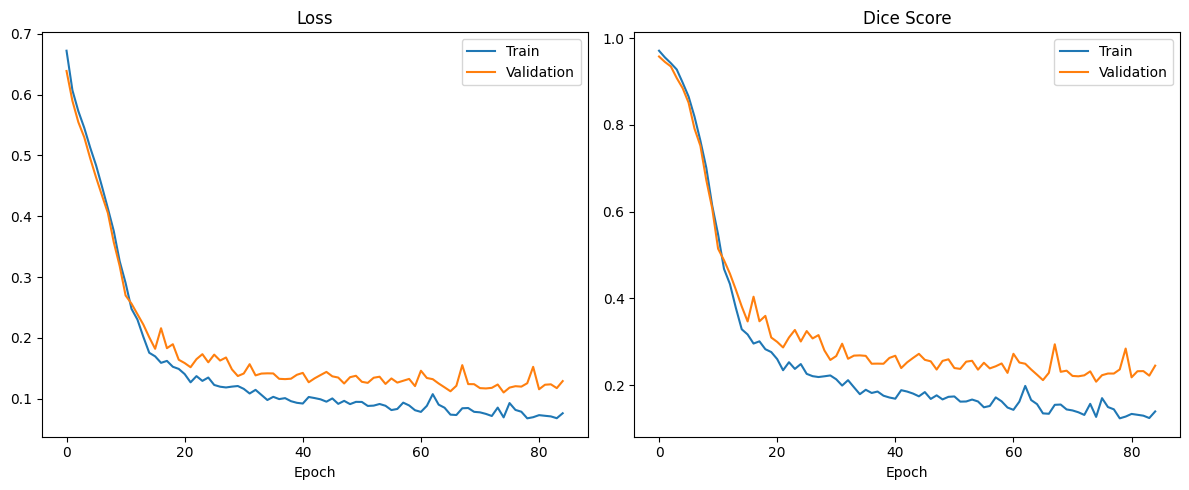

Evaluating: 100%|██████████| 589/589 [00:04<00:00, 144.86it/s]


Test Dice Score: 0.8891


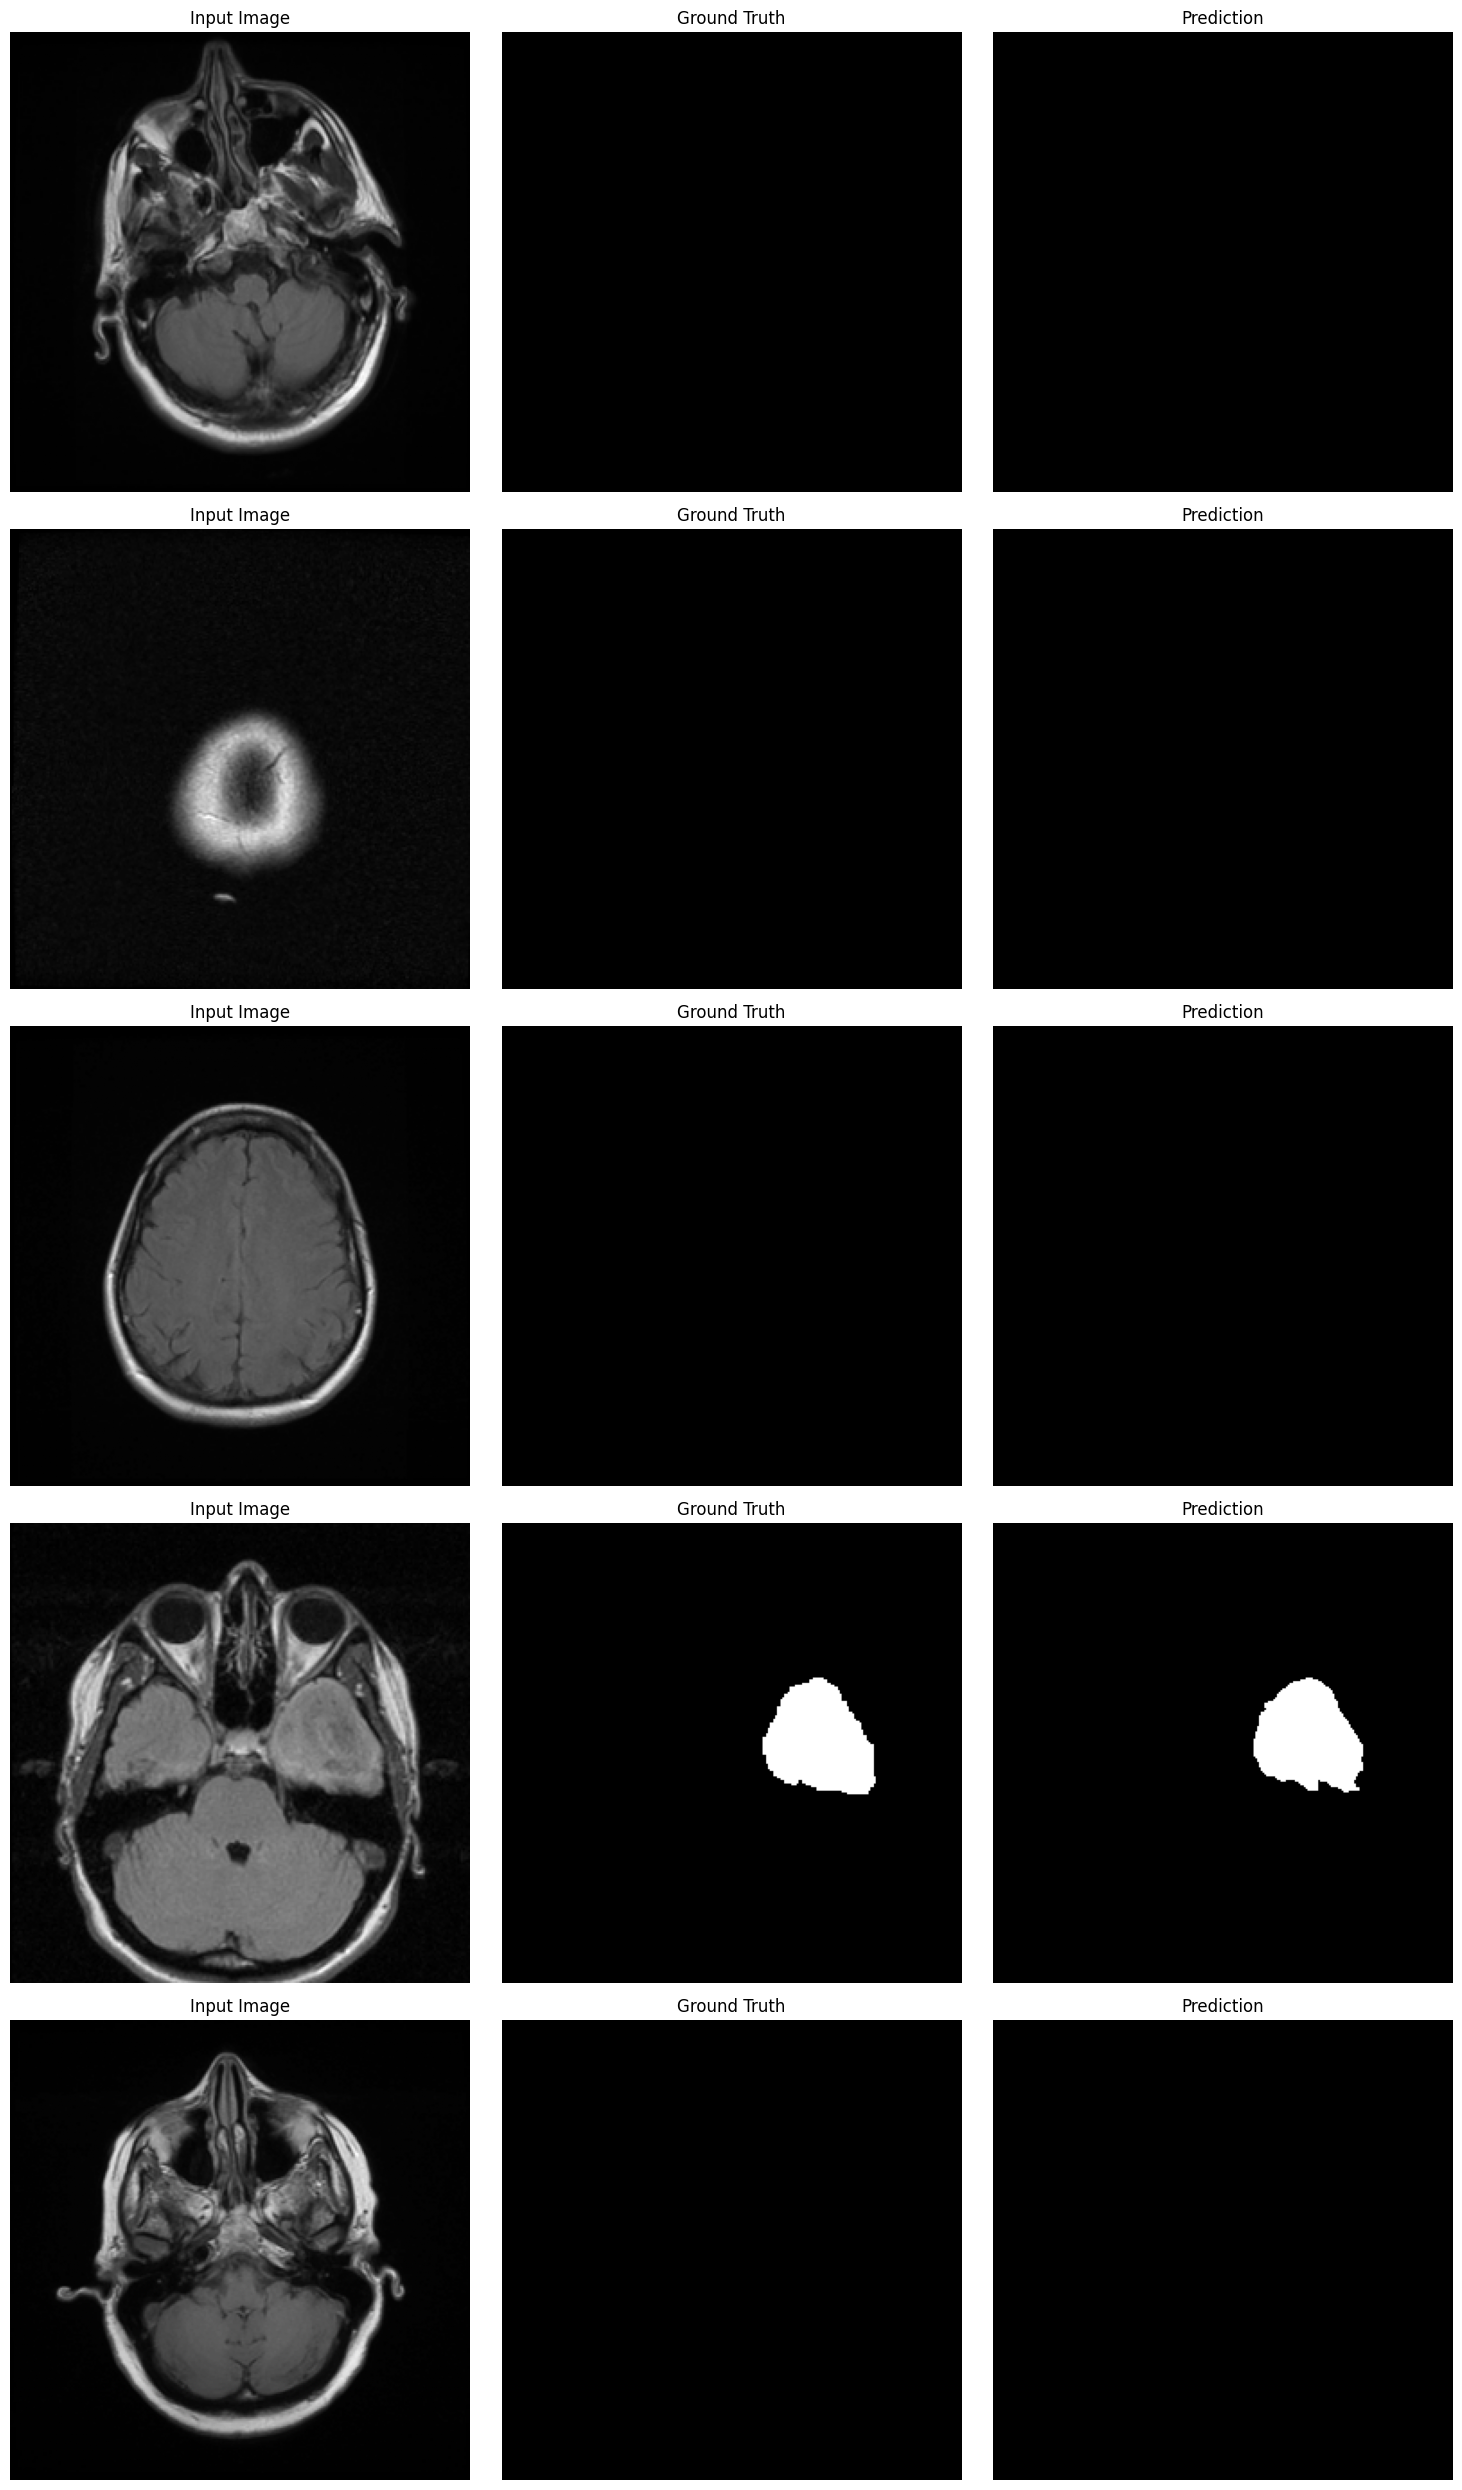

In [2]:
from segmentation import run_segmentation_pipeline

my_model = AttentionResUNet(in_channels=1, out_channels=1)

# Run the pipeline with custom model and naming
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="Attresunet",
    batch_size=7,
    patience=10
)